In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
df = pd.read_csv(r"C:\Users\comp\Desktop\kuki\vs code\lab3\lab-3\ML\uber.csv")

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
print("Shape of dataset:", df.shape)
print("\nDataset Info:")
print(df.info())

Shape of dataset: (200000, 9)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None


In [5]:
print("\nMissing values in each column:")
print(df.isnull().sum())



Missing values in each column:
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [6]:
df.describe()


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [10]:
# Step 4: Data Preprocessing

# Drop columns not required (like id, key, or timestamp if irrelevant)
df.drop(['id', 'key'], axis=1, errors='ignore', inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# If dataset has date-time columns, convert them to datetime format
if 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month

# Drop rows where fare_amount or distance <= 0 (invalid data)
if 'fare_amount' in df.columns:
    df = df[df['fare_amount'] > 0]

# Reset index
df.reset_index(drop=True, inplace=True)

print("Data after preprocessing:")
df.head()


Data after preprocessing:


,Unnamed: 0,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6
4,17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8


In [12]:
# Step 5: Outlier Detection

# Visualize outliers using boxplots
numeric_cols = df.select_dtypes(include=np.number).columns


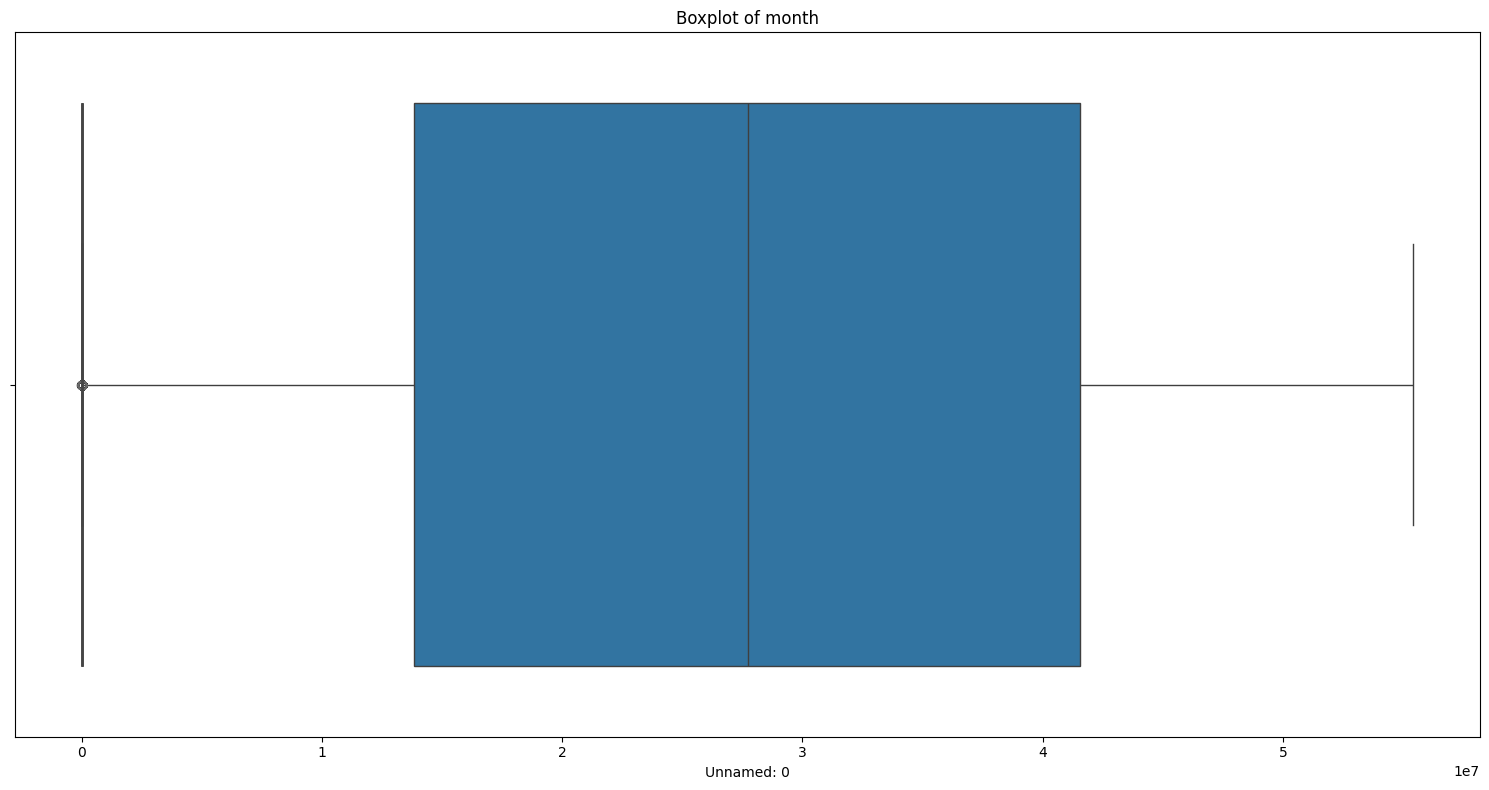

In [15]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    # plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
# plt.show()



In [16]:

# Optionally remove outliers using IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

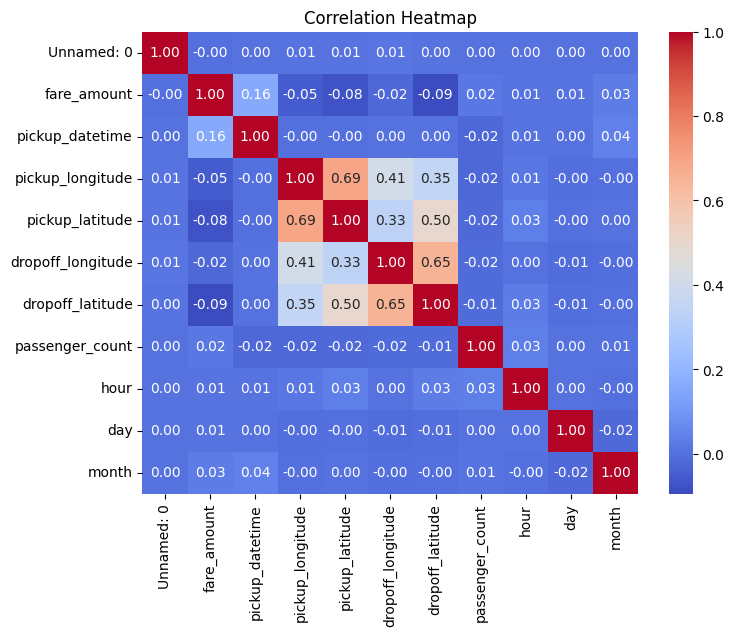

In [17]:
# Step 6: Correlation Analysis
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [18]:
# Step 7: Feature Selection

# Example: Assuming fare_amount is the target variable
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (118452, 10)
Testing data shape: (29614, 10)


In [23]:
# Step 7 (Fixed): Feature Selection

# Drop any non-numeric columns like datetime or string-based data
X = df.drop('fare_amount', axis=1)
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns

y = df['fare_amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Numeric features used for training:")
print(X_train.columns)


Numeric features used for training:
Index(['Unnamed: 0', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'day', 'month'],
      dtype='object')


In [24]:
# Step 8: Linear Regression Model

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

# Evaluation
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression Results:")
print("R² Score =", round(r2_lr, 3))
print("RMSE =", round(rmse_lr, 3))


Linear Regression Results:
R² Score = 0.013
RMSE = 3.803


In [ ]:
# Step 9: Random Forest Regression

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluation
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Regression Results:")
print("R² Score =", round(r2_rf, 3))
print("RMSE =", round(rmse_rf, 3))


In [ ]:
# Step 10: Model Comparison
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest Regression"],
    "R² Score": [r2_lr, r2_rf],
    "RMSE": [rmse_lr, rmse_rf]
})

print("\nModel Comparison:")
print(results)


In [ ]:
# Step 11: Visualize Actual vs Predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression', alpha=0.6)
plt.scatter(y_test, y_pred_rf, color='red', label='Random Forest', alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices Comparison")
plt.legend()
plt.show()


In [ ]:
# Step 12: Conclusion
print("✅ Model Evaluation Complete!")

if r2_rf > r2_lr:
    print("Random Forest performs better based on R² and RMSE values.")
else:
    print("Linear Regression performs better based on R² and RMSE values.")
